# ::1:: - Gaussian Process - A first glance

In [95]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import style

from random import sample

## Data

Introduce a small set of data points.

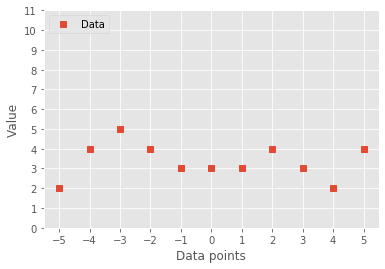

In [355]:
y_max = 12
x = range(-5, 5 + 1)
y = np.array([np.random.randint(y_max / 6, y_max / 2) for i in x])
style.use('ggplot')
plt.plot(x, y, 's', label='Data')
plt.xticks(x)
plt.yticks(range(y_max))
plt.xlabel('Data points')
plt.ylabel('Value')
plt.legend(loc='upper left')
plt.show()

## Fit a line

As we aspire on fitting the best line to the data points $(x,y)$, we will formulate a projection problem and make use of a least squares approximation method. Hence a solution is sought solely by making use of linear algebra.

We are looking for the line: $b = C + Dx$

However, no line can possible go through all of the points $(x_i,y_i)$. Hence we have that: $Ax \neq b$ where $A \, \in \, \mathbb R^{m\,x\,n}$, and where $m\, \in \, \mathbb R^{xnum = 4}$ and $n\, \in \,\mathbb R^2$.

Instead we can construct a projection matrix $A^TA$ and operate on a least squares solution vector $\hat x$. Solving $A^TA\hat x = A^Tb$ gives a vector $p = A\hat x$ as a projection $b$ onto the columnspace of $A$. 

Note that $\hat x$ gives us the least squares in terms of $\| b - A\hat x \|^2 =$ minimum.

Note that fitting this line gets done in 1 timestep.

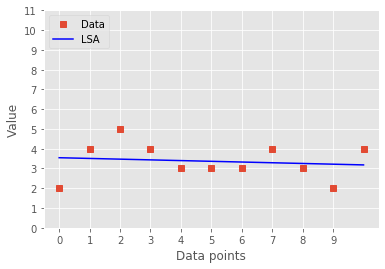

In [356]:
b = y
A = np.array((np.ones(len(x)), x))
AT = np.transpose(A)
ATA = np.matmul(A, AT)
ATb = np.matmul(np.transpose(b), AT)
x_hat = np.linalg.solve(ATA, ATb)
p = np.matmul(AT, x_hat)
plt.plot(y, 's', label='Data')
plt.plot(p, color='blue', label='LSA')
plt.xticks(range(x_num))
plt.yticks(range(y_max))
plt.xlabel('Data points')
plt.ylabel('Value')
plt.legend(loc='upper left')
plt.show()

## Gaussian Process

A Gaussian Process (GP) is a predictive machine learning application of the generalized multivariate Gaussian distribution. A GP is a prior over functions $p(f)$ that can be used for baysean regression. 

A GP takes as arguments a set of inputs: 

$${\bf X} = (x_1, x_2, x_3, ..., x_N)$$ 

Alongside a corresponding set of random function variables:

$${\bf f} = (f_1, f_2, f_3, ..., f_N)$$

Any set of function variables has a joint zero mean Gaussian distribution:

$$p({\bf f} | {\bf X}) = N(0,\bf K)$$

Where $\bf K$ is the co-variance matrix of the kernel function taking the variable pair $(x,\,x^*)$ as its argument. Hence the GP distribution can be expressed as a normal distribution, with a mean function ${\bf \mu} (x,\, x^*)$ and a co-variance function ${\bf K} (x,\,x^*)$ as its parameters:

$$p_{\bf GP}(f^*|x^*,\,x,\,f) = \begin{pmatrix}f \\ f^* \end{pmatrix} \sim \begin{pmatrix}\, 0, \begin{pmatrix}{\bf K}_{x,x} & {\bf K}_{x,x^*} \\ {\bf K}_{x^*,x} & {\bf K}_{x^*x^*}\end{pmatrix}\end{pmatrix}$$

Where:
* $x,\,f \in \mathbb R^n$ are an $n$ dimensional input features vector, and an output values vector of the training data set. 
* $x^*,\,f^* \in \mathbb R^m$ are an $m$ dimensional input features vector, and an output distribution vector of the target.
* ${\bf K}_{x,x} \in \mathbb R^{n\,x\,n}$ is the $n\,x\,n$ dimensional co-variance matrix of training points.
* ${\bf K}_{x^*,x} \in \mathbb R^{m\,x\,n}$ is the $m\,x\,n$ dimensional co-variance matrix between each test and training point.
* ${\bf K}_{x^*,x^*} \in \mathbb R^{m\,x\,m}$ is the $m\,x\,m$ dimensional co-variance matrix between testpoints.

In order to obtain a co-variance matrix, there are several kernel functions to choose from. For our purposes we will make use to the most widely used, Squared exponential (SE) co-variance, or simply Gaussian, or Radial basis function kernel etc. The intuition is that function variables who are close in input space are highly correlated, meanwhile those far away are uncorrelated. 

The radial basis kernel function works in two steps:
1. get the squared distances between the variables
2. obtain a measurement of similarity

$${\bf K}(x,\,x^*) = \exp \bigg[-\begin{pmatrix}\frac{\|x - x^*\|}{2\sigma^2}\end{pmatrix}^2 \bigg]$$

Where $\sigma^2$ is a noise adding hyperparameter. Note that there are several more hyperparameters available for those who whish to tune the behaviour of a GP further.

Lets allow for a quick **recap** over where we are with all this. So there are some points $x$ for which we have observed the values $f(x)$, or simply $f$ as denoted above. There are furthermore typically a smaller subset of some points $x^*$ for which we would like to estimate the distribution $f^*$, hence we are seeking to obtain the probability distribution $p(f^*|x^*,\,x,\,f)$ and we are assuming that $f$ and $f^*$ together are jointly gaussian distributed.

In the following we will:
* define a **kernel** function that takes in various variables and gives back a co-variance matrix $\bf K$, over those variables.
* perform a **choelsky** decomposition $\bf L$ of ${\bf K}$ representing its 'square root'.
* obtain $n$ **f_prior** distributions by sampling $n$ number of standard normal distributions and taking their respective dot product with ${\bf LK}(x,\,x)$.
* present the model to $m$ observations from the training data $((x^*,\,f),)_m$ and calculate the target distribution **f_posterior** = $p(f^*|x,x^*,f)$ given the new information.
* repeat and calculate tomorrows posteriori given the posteriori of today as prior 

In [505]:
def kernel(a, b, l=0.1):
    '''
    Takes in a set of function variables, calculates the squared distances
    and converts it into a measure of similarity. Returns a covariance matrix.
    
    '''
    sqdist = np.sum(a**2, 1).reshape(-1, 1) + np.sum(b**2, 1) - 2*np.dot(a, b.T)
    return np.exp(-.5 * 1/l * sqdist)

def cholesky(K):
    '''
    Decomposes the co-variance matrix K into the product of its lower trianle L
    and the conjugate transpose of L. LLdagger. Returns the lower triangle matrix L.
    
    Some noise is added to the diagonal.
    
    '''
    return np.linalg.cholesky(K + 1e-15 * np.eye(len(K)))

def prior(L, n=1):
    '''
    Samples n standard normal distributions of size len(L), multiplies them with the 
    cholesky decomposition L.
    
    '''
    return np.matmul(L, np.random.normal(size=(len(L), n)))
    
def posterior(X, y_pred, updated_sigma, n=1):
    '''
    Sample n normal distributions of size len(L) with updated parameters y_pred
    and updated_sigma.
    
    '''
    L = cholesky(kernel(X, X))    
    p1 = np.random.normal(size=(len(L), n))
    p2 = np.matmul(L, np.random.normal(size=(len(L), n)))
    p3 = np.matmul(L, np.random.normal(size=(len(L), n))) + y_pred
    return p1, p2, p3

### Prior distribution

Sample distributions before any actual data points have been seen by the gaussian. Note how low they are in relation to the values of our data set. They are clearly spreading density around its zero mean which we quite arbitrary explicitly have assigned it, all according to our expectations in other words. 

Expect furthermore ahead the posterior distribution to quite rapidly shift north by adjusting its mean upwards. From there it will be interesting to see how it behavious. 



f_prior mean =  0.1806


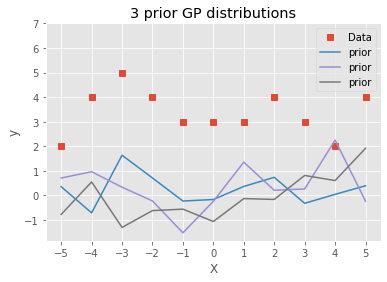

In [358]:
X = np.array(x).reshape(-1, 1)
Kxx = kernel(X, X)
L = cholesky(Kxx)
f_prior = prior(L, n=3)
print('f_prior mean = ', round(np.mean(f_prior), 4))
plt.title('3 prior GP distributions')
plt.plot(x, y, 's', label='Data')
plt.plot(x, f_prior, label='prior')
plt.xticks(x)
plt.ylim(top=np.amax(y) + 2)
plt.xlabel('X')
plt.ylabel('y')
plt.legend(loc='best')
plt.show()

### Posterior distribution

For each iteration/update we will need to calculate the mean and co-variance functions with respect to each new data point that we observe. These two equations can be expressed as follows:

$$\mu(f^*) = \mathbb E [f^*|X,y,X^*] = K(X^*,X)[K(X,X) + \sigma^2_n I]^{-1}y$$

$$cov(f^*) = K(X^*,X^*) - K(X^*,X)[K(X,X) + \sigma^2_n]^{-1}K(X^*,X)^T$$

Here we can see the core computation make its apperance in terms of calculating the inverse  in both cases. Note that these inverses will have to be calcultated each iteration, and furthermore that the size of these inverses scale with each new observation? O(?). *update* or do they? Or is it a matter of doing one gigantic inverse calculation over the entire training set, and then one can use that for both the mean and co-variance functions?

In [566]:
def new_predict(X, y, o):
    '''
    Calculates the mu and K functions with respect to the prior and one new 
    observation.
    
    obs - observation in terms of x-value
    X - training data
    y - training outputs
    
    Returns updated mean and co-variance parameters.
    
    '''
    obs = np.array(o).reshape(-1, 1)
    Kx = cholesky(kernel(X, X))
    Kxx = kernel(X, obs)
    Kxxx = kernel(obs, obs)
    print(Kx.shape, Kxx.shape, Kxxx.shape)
    y_pred = np.matmul(np.matmul(Kxx.T, np.linalg.inv(Kx + 1e-6*np.eye(len(X)))), y)
    updated_sigma = Kxxx - np.matmul(np.matmul(
            Kxx.T, np.linalg.inv(Kx + 1e-6*np.eye(len(X)))), Kxx)
    return y_pred, updated_sigma

(11, 11) (11, 1) (1, 1)
updated mean: [2.02690499]
updated co-variance: [[-2.16997536e-05]]


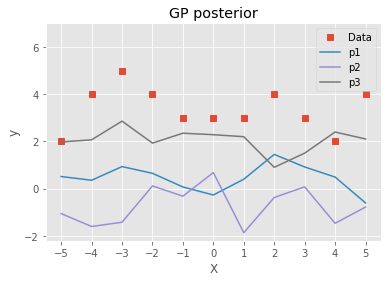

In [567]:
y_pred, updated_sigma = new_predict(X, y, o=(4,))
print('updated mean:', y_pred)
print('updated co-variance:', updated_sigma)
p1, p2, p3 = posterior(X, y_pred, updated_sigma, n=1)
plt.title('GP posterior')
plt.plot(x, y, 's', label='Data')
plt.plot(x, p1, label='p1')
plt.plot(x, p2, label='p2')
plt.plot(x, p3, label='p3')
plt.xticks(x)
plt.ylim(top=np.amax(y) + 2)
plt.xlabel('X')
plt.ylabel('y')
plt.legend(loc='best')
plt.show()

### Moving on

Nice job with this, but its time to implement a new cleaner one, see ya there.